In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from sklearn import metrics

In [2]:
training_df = pl.read_csv('data/training_smiles.csv')

## Feature engineering

In [3]:
features_dict = {
    "MolWeight": pl.Float64,
    "Fragments": pl.Int64,
    "Lipinski-HAcount": pl.Int64,
    "LogP": pl.Float64,
    "TPSA": pl.Float64,
    "HBD": pl.Int64,
    "HBA": pl.Int64,
}
base_features = list(features_dict.keys())

In [ ]:
from rdkit.Chem import rdMolDescriptors as d
import rdkit.Chem.Fragments as f
from rdkit.Chem import Lipinski as l
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

generator = GetMorganGenerator(radius=2, fpSize=1024)

# Define a function to calculate all features
def calculate_all_features(smiles):

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None, None
    
    mol_weight = d.CalcExactMolWt(mol)
    #print(f"molwt {mol_weight}")
    fragments = f.fr_Al_COO(mol)
    #print(f"fragments {fragments}")
    lipinski = l.HeavyAtomCount(mol)
    #print(f"lipinski {lipinski}")
    logp, _ = d.CalcCrippenDescriptors(mol)
    #print(f"logp {logp}")
    tpsa = d.CalcTPSA(mol)
    #print(f"tpsa {tpsa}")
    hbd = d.CalcNumHBD(mol)
    #print(f"hbd {hbd}")
    hba = d.CalcNumHBA(mol)
    #print(f"hba {hba}")
    
    fingerprint = np.array(generator.GetFingerprint(mol))
    fingerprint = [int(bit) for bit in fingerprint]
    # print(fingerprint.sum())

    return mol_weight, fragments, lipinski, logp, tpsa, hbd, hba, *fingerprint  # Unpack the fingerprint array

# First add base features with the working fix
training_df = training_df.with_columns([
    pl.col("SMILES").map_elements(
        lambda x, idx=i: calculate_all_features(x)[idx],  # Use idx parameter to capture the correct index
        return_dtype=features_dict[feature]
    ).alias(feature) 
    for i, feature in enumerate(base_features)
])

# Then, add the fingerprint columns with the same fix
fingerprint_columns = [
    pl.col("SMILES").map_elements(
        lambda x, idx=i: calculate_all_features(x)[7 + idx],  # Offset by 7 to get to fingerprint values
        return_dtype=pl.Int64
    ).alias(f"Fingerprint_{i}") 
    for i in range(1024)
]

training_df = training_df.with_columns(fingerprint_columns)

# Update features list to include fingerprint columns
features = list(features_dict.keys()) + [f"Fingerprint_{i}" for i in range(1024)]

[21:45:07] WARNING: not removing hydrogen atom without neighbors
[21:45:30] WARNING: not removing hydrogen atom without neighbors
[21:45:54] WARNING: not removing hydrogen atom without neighbors
[21:46:16] WARNING: not removing hydrogen atom without neighbors
[21:46:35] WARNING: not removing hydrogen atom without neighbors
[21:46:55] WARNING: not removing hydrogen atom without neighbors


In [ ]:
training_df.select(features)

In [48]:
training_df.select(features).corr()

/home/san/.pyenv/versions/3.11.9/envs/id2214-4/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/san/.pyenv/versions/3.11.9/envs/id2214-4/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


MolWeight,Fragments,Lipinski-HAcount,LogP,TPSA,HBD,HBA,Fingerprint_0,Fingerprint_1,Fingerprint_2,Fingerprint_3,Fingerprint_4,Fingerprint_5,Fingerprint_6,Fingerprint_7,Fingerprint_8,Fingerprint_9,Fingerprint_10,Fingerprint_11,Fingerprint_12,Fingerprint_13,Fingerprint_14,Fingerprint_15,Fingerprint_16,Fingerprint_17,Fingerprint_18,Fingerprint_19,Fingerprint_20,Fingerprint_21,Fingerprint_22,Fingerprint_23,Fingerprint_24,Fingerprint_25,Fingerprint_26,Fingerprint_27,Fingerprint_28,Fingerprint_29,…,Fingerprint_987,Fingerprint_988,Fingerprint_989,Fingerprint_990,Fingerprint_991,Fingerprint_992,Fingerprint_993,Fingerprint_994,Fingerprint_995,Fingerprint_996,Fingerprint_997,Fingerprint_998,Fingerprint_999,Fingerprint_1000,Fingerprint_1001,Fingerprint_1002,Fingerprint_1003,Fingerprint_1004,Fingerprint_1005,Fingerprint_1006,Fingerprint_1007,Fingerprint_1008,Fingerprint_1009,Fingerprint_1010,Fingerprint_1011,Fingerprint_1012,Fingerprint_1013,Fingerprint_1014,Fingerprint_1015,Fingerprint_1016,Fingerprint_1017,Fingerprint_1018,Fingerprint_1019,Fingerprint_1020,Fingerprint_1021,Fingerprint_1022,Fingerprint_1023
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,NaN,0.97001,0.816345,0.669717,0.312616,0.680849,NaN,NaN,NaN,0.421592,-0.267124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.421592,NaN,NaN,0.039632,-0.570957,NaN,0.138871,NaN,0.421695,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.394717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.198997,NaN,NaN,NaN,NaN,NaN,NaN,-0.119524,NaN,0.208042,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.97001,NaN,1.0,0.780949,0.778911,0.375114,0.711441,NaN,NaN,NaN,0.2793,-0.247681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2793,NaN,NaN,0.121205,-0.490092,NaN,0.221332,NaN,0.54279,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.445037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.194983,NaN,NaN,NaN,NaN,NaN,NaN,-0.055333,NaN,0.361433,NaN,NaN,NaN,NaN
0.816345,NaN,0.780949,1.0,0.563217,0.458457,0.282968,NaN,NaN,NaN,0.560574,-0.129469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.560574,NaN,NaN,-0.073754,-0.349184,NaN,-0.251516,NaN,0.640819,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.128758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.287796,NaN,NaN,NaN,NaN,NaN,NaN,-0.271163,NaN,0.107775,NaN,NaN,NaN,NaN
0.669717,NaN,0.778911,0.563217,1.0,0.59171,0.768306,NaN,NaN,NaN,-0.209466,-0.368325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.209466,NaN,NaN,0.292168,-0.540342,NaN,0.317829,NaN,0.771131,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.179296,NaN,NaN,NaN,NaN,NaN,NaN,0.084654,NaN,0.506174,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.208042,NaN,0.361433,0.107775,0.506174,0.037113,0.353919,NaN,NaN,NaN,-0.272166,0.408248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.272166,NaN,NaN,0.408248,0.102062,NaN,0.612372,NaN,0.408248,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.356348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.272166,NaN,NaN,NaN,NaN,NaN,NaN,0.102062,NaN,1.0,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [8]:
# Optional: Save the training features df
training_df.write_parquet("final_enriched_training_df.parquet")

## Make prediction

In [3]:
# training_df = pl.read_parquet("enriched_training_df.parquet")

In [4]:
from sklearn.model_selection import train_test_split

X = training_df[features]
y = training_df[['ACTIVE']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [5]:
value_counts = training_df['ACTIVE'].value_counts()
print("Raw counts:")
print(value_counts)

# Actual ratio
ratio = (value_counts.filter(pl.col("ACTIVE") == 0.0)["count"] / value_counts.filter(pl.col("ACTIVE") == 1.0)["count"]).item()
print("\nCalculated ratio (negative/positive):")
print(ratio)

Raw counts:
shape: (2, 2)
┌────────┬────────┐
│ ACTIVE ┆ count  │
│ ---    ┆ ---    │
│ f64    ┆ u32    │
╞════════╪════════╡
│ 1.0    ┆ 7933   │
│ 0.0    ┆ 201005 │
└────────┴────────┘

Calculated ratio (negative/positive):
25.33782932055969


In [ ]:
# Use GridSearchCV to find the best parameters for XGBoost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

params = {
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [5, 10, 20, 50, 100],
    # 'scale_pos_weight': [1, ratio],
    'objective': ['binary:logistic', 'binary:hinge', 'binary:logitraw']
}
grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42, eval_metric='auc'), param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_params

In [6]:
from xgboost import XGBClassifier

best_params = {'learning_rate': 0.1,
 'max_depth': 11,
 'n_estimators': 100,
 'objective': 'binary:logistic'}

# Taken from https://xgboost.readthedocs.io/en/stable/get_started.html
bst = XGBClassifier(
    **best_params,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='auc'
)

In [7]:
X_train, y_train

(shape: (167_150, 6)
 ┌────────────┬───────────┬─────────┬────────┬─────┬─────┐
 │ MolWeight  ┆ Fragments ┆ LogP    ┆ TPSA   ┆ HBD ┆ HBA │
 │ ---        ┆ ---       ┆ ---     ┆ ---    ┆ --- ┆ --- │
 │ f64        ┆ i64       ┆ f64     ┆ f64    ┆ i64 ┆ i64 │
 ╞════════════╪═══════════╪═════════╪════════╪═════╪═════╡
 │ 272.09094  ┆ 0         ┆ 1.94448 ┆ 114.95 ┆ 1   ┆ 6   │
 │ 314.101505 ┆ 0         ┆ 2.0523  ┆ 113.36 ┆ 1   ┆ 8   │
 │ 334.074913 ┆ 0         ┆ 2.0408  ┆ 86.68  ┆ 0   ┆ 9   │
 │ 361.216555 ┆ 0         ┆ 2.3552  ┆ 61.44  ┆ 2   ┆ 3   │
 │ 420.136446 ┆ 0         ┆ 3.1279  ┆ 76.46  ┆ 1   ┆ 5   │
 │ …          ┆ …         ┆ …       ┆ …      ┆ …   ┆ …   │
 │ 321.036441 ┆ 0         ┆ 3.466   ┆ 38.33  ┆ 1   ┆ 3   │
 │ 431.19574  ┆ 0         ┆ 1.9809  ┆ 90.92  ┆ 1   ┆ 7   │
 │ 363.057215 ┆ 0         ┆ 1.56162 ┆ 107.71 ┆ 1   ┆ 10  │
 │ 388.168145 ┆ 0         ┆ 2.2593  ┆ 92.27  ┆ 2   ┆ 8   │
 │ 348.104084 ┆ 0         ┆ 3.3055  ┆ 58.2   ┆ 2   ┆ 2   │
 └────────────┴───────────┴────────

In [8]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# GridSearchCV of Logistic Regression
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV

#class_weights = {0.0: 1, 1.0: ratio}

#params = {
#    'penalty': ['l1', 'l2', 'elasticnet'],
#    'C': [0.01, 0.1, 1, 10, 100],
#    'fit_intercept': [True, False],
#    'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'],
    # 'class_weight': [class_weights, 'balanced', None]
#}
#grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=params, cv=5, scoring='roc_auc')
#grid_search.fit(X_train, y_train)
#best_params = grid_search.best_params_
#best_params

In [ ]:
from sklearn.linear_model import LogisticRegression

class_weights = {0.0: 1, 1.0: ratio}

best_params = {'C': 0.1,
 # 'class_weight': None,
 'fit_intercept': True,
 'penalty': 'l1',
'solver': 'liblinear'}

clf = LogisticRegression(**best_params, random_state=42, class_weight=class_weights)

In [ ]:
clf.fit(X_train, y_train)

## Evaluation

### Logistic Regression

In [ ]:
clf_train_preds = clf.predict(X_train)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, clf_train_preds)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
val_preds = rf = clf.predict(X_test)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, val_preds)
auc = metrics.auc(fpr, tpr)
auc

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [9]:
train_preds = bst.predict(X_train)

In [10]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, train_preds)
auc = metrics.auc(fpr, tpr)
auc

np.float64(0.9195509835766731)

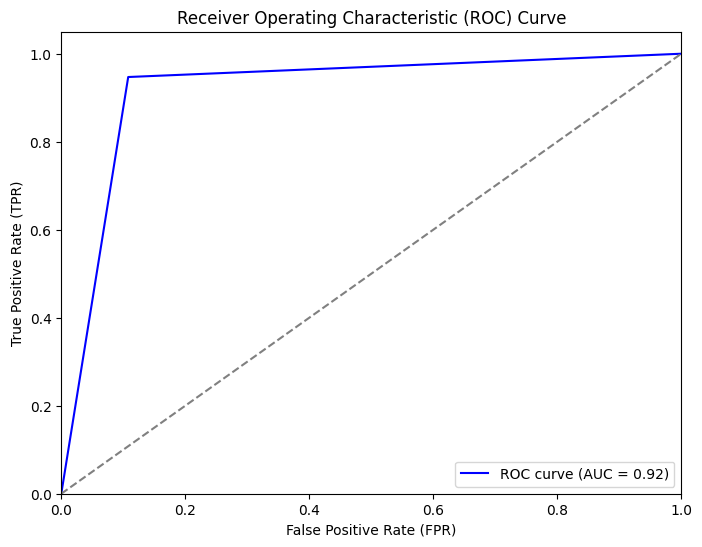

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
val_preds = bst.predict(X_test)

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, val_preds)
auc = metrics.auc(fpr, tpr)
auc

np.float64(0.6733612086975613)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Estimation + writing to file

In [ ]:
test_df = pl.read_csv('data/test_smiles.csv')
test_df

In [ ]:
test_df = test_df.with_columns([
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[0], return_dtype=pl.Float64).alias(features[0]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[1], return_dtype=pl.Int64).alias(features[1]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[2], return_dtype=pl.Int64).alias(features[2]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[3], return_dtype=pl.Float64).alias(features[3]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[4], return_dtype=pl.Float64).alias(features[4]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[5], return_dtype=pl.Int64).alias(features[5]),
    pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[6], return_dtype=pl.Int64).alias(features[6]),
    # pl.col("SMILES").map_elements(lambda x: calculate_all_features(x)[3], return_dtype=pl.String).alias("MorganFingerprints")
])

In [ ]:
train_preds = bst.predict_proba(test_df[features])

We have excluded a part of the training set to be our validation set, and we thus expect the AUC in the test set to match it. Based on our best performing model - the XGBooster model, the value should be **0.5944**.

In [ ]:
## Alternatively, we can look at the OOB performance - but it might benefit from overfitting, 
# due to it not being fully indepedent (in contrast to validation set performance).
best_params = {'learning_rate': 0.1,
 'max_depth': 11,
 'n_estimators': 50,
 'objective': 'binary:logistic'}

bst = XGBClassifier(
    **best_params,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='auc',
    # enable_categorical=True,  # Enable categorical features
    subsample=0.8,
)

bst.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import roc_auc_score
oob_predictions = bst.predict_proba(X_train)[:, 1]
oob_auc = roc_auc_score(y_train, oob_predictions)
print(f"Training OOB AUC-ROC: {oob_auc}")

In [ ]:
from sklearn.metrics import roc_auc_score
val_oob_predictions = bst.predict_proba(X_test)[:, 1]
val_oob_auc = roc_auc_score(y_test, val_oob_predictions)
print(f"Validation OOB AUC-ROC: {val_oob_auc}")

### Writing to file

In [ ]:
with open("10.txt", "w") as f:
    f.write(f"{auc}\n")
    for pred in train_preds:
        positive_pred = pred[1]
        f.write(f"{positive_pred}\n")

In [ ]:
predictions_df = pd.read_csv("10.txt", header=None)
assert predictions_df.shape == (69646+1, 1)
assert np.all((predictions_df.values >= 0) & (predictions_df.values <= 1))